# Part 1: Policy Gradients

**Before doing this, be sure you review the `README.md` file from the homework!**



You will implement the vanilla policy gradients algorithm, also referred to as
REINFORCE.

## Review

In policy gradients, the objective is to learn a parameter $\theta^*$ that
maximizes the following objective:

\begin{equation}\label{eq:pg}
J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta(\tau)}[R(\tau)]
\end{equation}

where $\tau = (s_1,a_1,s_2,\ldots,s_{T-1},a_{T-1},s_T)$ is a *trajectory*
(also referred to as an *episode*), and factorizes as

\begin{equation}\label{eq:factorization}
\pi_\theta(\tau) = p(s_1)\pi_\theta(a_1|s_1)\prod_{t=2}^{T} p(s_t|s_{t-1},a_{t-1})\pi_\theta(a_t|s_t)
\end{equation}

and $R(\tau)$ denotes the full trajectory reward $R(\tau) = \sum_{t=1}^{T}
r(s_t,a_t)$ with $r(s_t,a_t)$ the rewards at the individual time steps.

In policy gradients, we directly apply the gradient $\nabla_\theta$ to
$J(\theta)$. In order to do so, we require samples of trajectories, meaning that
we now denote them as $\tau_i$ for the $i$th trajectory, and have $\tau_i =
(s_{i1},a_{i1},s_{i2},\ldots,s_{iT})$. When we approximate the gradient with
samples, we get:

\begin{align*}
\nabla_\theta J(\theta) &\approx \frac{1}{N} \sum_{i=1}^N \nabla_\theta \log \pi_\theta(\tau_i) R(\tau_i) \\
&= \frac{1}{N}\sum_{i=1}^N \left( \sum_{t=1}^T \nabla_\theta \log \pi_\theta(a_{it}|s_{it}) \right)  \left( \sum_{t=1}^{T} r(s_{it},a_{it}) \right)
\end{align*}

Multiplying a discount factor $\gamma$ to the rewards can be interpreted as
encouraging the agent to focus on rewards closer in the future, which can also
be thought of as a means for reducing variance (because there are more
possible futures further into the future). The discount factor can be
incorporated in two ways, from the full trajectory:

\begin{equation}\label{eq:full_traj}
\nabla_\theta J(\theta) \approx \frac{1}{N} \sum_{i=1}^N
\left( \sum_{t=1}^T \nabla_\theta \log \pi_\theta(a_{it}|s_{it}) \right) 
\left( \sum_{t=1}^T \gamma^{t-1} r(s_{it},a_{it}) \right)
\end{equation}

and from the reward to go:

\begin{equation}\label{eq:to_go}
\nabla_\theta J(\theta) \approx \frac{1}{N} \sum_{i=1}^N
\left( \sum_{t=1}^T \nabla_\theta \log \pi_\theta(a_{it}|s_{it}) \right) 
\left( \sum_{t'=t}^T \gamma^{t'-t} r(s_{it},a_{it}) \right)
\end{equation}

You will implement both versions in this assignment.

*Remark*: It's possible to reduce variance by subtracting a (learned) baseline
function, though for this assignment we will not do that.



# Policy Gradients Implementation (Look at `train_pg.py`)


**You will need to write code in `train_pg.py`. The places where you need to write code are
 clearly indicated with the comments `START OF YOUR CODE` and
`END OF YOUR CODE`. 
You do not need to change any other files for this part of the assignment.**

The function `train_PG` is used to perform the training for policy
gradients. The parameters passed into this function specify the algorithm’s
hyperparameters and environment. The `Agent` class contains methods that
define the computation graph, sample trajectories, estimate returns, and update
the parameters of the policy.  The dataflow of the code is structured like this:

- Build a static computation graph in Tensorflow.
- Set up a Tensorflow session to initialize the parameters of the
computation graph.  This is the only time you need to set up the session.

Then we will repeat Steps 3 through 5 for $N$ iterations:

- Sample trajectories by executing the Tensorflow op that samples an
action given an observation from the environment. Collect the states, actions,
and rewards as numpy variables.
- Estimate returns in numpy, i.e., the estimated Q values.
- Update parameters by executing the Tensorflow op that updates the
parameters given what you computed in Step 4.


## Problem 1: Agent Computation Graph

Implement `Agent.build_computation_graph` by looking at any parts with
a "Problem 1" header in the code. Here's what you need to do:

- Define the placeholder for the advantages in `Agent.define_placeholders`. We have already done similar stuff for the
observations and actions. The advantages correspond to $R(\tau)$ in the policy
gradient.

- Create the symbolic operation `Agent.policy_forward_pass`: This
outputs the parameters of a distribution $\pi_\theta(a|s)$.  When the
distribution is over discrete actions these parameters will be the logits of a
categorical distribution, and when the distribution is over continuous actions
these parameters will be the mean and the log standard deviation of a
multivariate Gaussian distribution. This operation will be an input to
`Agent.sample_action` and `Agent.get_log_prob`.

- Create the symbolic operation `Agent.sample_action`: This produces a Tensorflow operation named `self.sy_sampled_ac` that samples an action from $\pi_\theta(a|s)$. This operation will be called in `Agent.sample_trajectories`.

- Create the symbolic operation `Agent.get_log_prob`: Given an
action that the agent took in the environment, this computes the log probability
of that action under $\pi_\theta(a|s)$. This will be used in the loss function.

- In `Agent.build_computation_graph` implement a loss function (which uses the result from `Agent.get_log_prob`) to whose gradient is $\nabla_\theta J(\theta)$. Set this as `self.loss`.


## Problem 2: Policy Gradient Loop

An RL algorithm can viewed as consisting of three parts, which are reflected in
the training loop of `train_PG`:

- `Agent.sample_trajectories`: Generate samples by running the agent's policy.
- `Agent.estimate_return`: Estimate the return by summing together (potentially discounted) rewards from the trajectories.
- `Agent.update_parameters`: Improve the policy by running gradient optimization updates with automatic differentiation via TensorFlow.

You only need to implement the parts with the "Problem 2" header.

- **Sample trajectories**: In `Agent.sample_trajectories`, use the Tensorflow session to call `self.sy_sampled_ac` to sample an action given an observation from the environment.

- **Estimate return, part 1**: We will now implement $R(\tau)$.  Implement `Agent.sum_of_rewards`, which will return a sample estimate of the discounted return, for both the full-trajectory and reward to go. Concretely, these are:

  \begin{equation}
  R(\tau_i) = \sum_{t=1}^T \gamma^{t-1} R(s_{it},a_{it})
  \end{equation}

  and

  \begin{equation}
  R(\tau_i) = \sum_{t'=t}^T \gamma^{t'-t} R(s_{it},a_{it})
  \end{equation}

  See the code comments for additional details.
  
- **Estimate return, part 2**: in `Agent.estimate_return`, normalize the advantages to have a mean of zero and a standard deviation of one.  This is a trick for reducing variance.

- **Update parameters**: In `Agent.update_parameters` use the Tensorflow session to call the update operation `self.update_op` to update the parameters of the policy. You need to create a dictionary `feed_dict` with the inputs.



Case 1: trajectory-based PG  (reward_to_go = False)

Instead of $Q^{pi}(s_t, a_t)$, we use the total discounted reward summed over
entire trajectory (regardless of which time step the Q-value should be for).

For this case, the policy gradient estimator is

  \begin{equation}
  R(\tau_i) = \sum_{t=1}^T \gamma^{t-1} R(s_{it},a_{it})
  \end{equation}

\begin{equation}
E_{\tau} [\sum_{t=0}^T \nabla \log \pi(a_t|s_t) * Ret(\tau)]
\end{equation}

where $Ret(\tau) = sum_{t'=0}^T gamma^t' r_{t'}$

Thus, you should compute

$Q_t = Ret(\tau)$

Case 2: reward-to-go PG  (reward_to_go = True)

Here, you estimate Q^{pi}(s_t, a_t) by the discounted sum of rewards starting
from time step t. Thus, you should compute

$Q_t = sum_{t'=t}^T gamma^{(t'-t)} * r_{t'}$

# Other Considerations (Code, Plotting, Logging, etc.)

Note that this assignment is structured slightly different from the prior ones in that you should be testing your code by running code via your command line. The plotting, though, will still be done here for reporting purposes. See the two deliverables later for what you should be plotting, and the commands for doing so, and further details on what information gets logged for plotting. Make sure that you don't change the deliverable cells apart from adjusting your log directory names, as the graders need consistency in seeing the results.

Load this cell for some initial setup.

In [3]:
%load_ext autoreload
%autoreload 2

# Ensure your Python version makes sense.
import sys
sys.version

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

import pandas as pd
import json, os


# Daniel note: tsplot() might be deprecated
def plot_data(data, value="AverageReturn"):
    if isinstance(data, list):
        data = pd.concat(data, ignore_index=True)
    sns.set(style="darkgrid", font_scale=1.5)
    sns.tsplot(data=data, time="Iteration", value=value, unit="Unit", condition="Condition")
    plt.legend(loc='best').set_draggable(True)
    plt.tight_layout()
    plt.show()


def get_datasets(fpath, condition=None):
    unit = 0
    datasets = []
    for root, dir, files in os.walk(fpath):
        if 'log.txt' in files:
            param_path = open(os.path.join(root,'params.json'))
            params = json.load(param_path)
            exp_name = params['exp_name']   
            log_path = os.path.join(root,'log.txt')
            #experiment_data = pd.read_table(log_path)
            experiment_data = pd.read_csv(log_path, sep='\t')
            experiment_data.insert(
                len(experiment_data.columns),
                'Unit',
                unit
            )        
            experiment_data.insert(
                len(experiment_data.columns),
                'Condition',
                condition or exp_name
            )
            datasets.append(experiment_data)
            unit += 1
    return datasets


def plot(logdir, head, legend, value='AverageReturn'):
    use_legend = False
    if legend is not None:
        assert len(legend) == len(logdir), "Must give a legend title for each set of experiments."
        use_legend = True

    data = []
    if use_legend:
        for logdir, legend_title in zip(logdir, legend):
            data += get_datasets(os.path.join(head,logdir), legend_title)
    else:
        for logdir in logdir:
            data += get_datasets(os.path.join(head,logdir))

    if isinstance(value, list):
        values = value
    else:
        values = [value]
    for value in values:
        plot_data(data, value=value)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Deliverable 1 of 2: Policy Gradients on CartPole-v0


## Commands to Run

Once you think you have finished implementing the above, then run these commands:

```
python train_pg.py CartPole-v0 -n 100 -b 1000 -e 3      -dna --exp_name sb_no_rtg_dna
python train_pg.py CartPole-v0 -n 100 -b 1000 -e 3 -rtg -dna --exp_name sb_rtg_dna
python train_pg.py CartPole-v0 -n 100 -b 1000 -e 3 -rtg      --exp_name sb_rtg_na
python train_pg.py CartPole-v0 -n 100 -b 5000 -e 3      -dna --exp_name lb_no_rtg_dna
python train_pg.py CartPole-v0 -n 100 -b 5000 -e 3 -rtg -dna --exp_name lb_rtg_dna
python train_pg.py CartPole-v0 -n 100 -b 5000 -e 3 -rtg      --exp_name lb_rtg_na
```


where

- `-n`: Number of iterations.

- `-b`: Batch size (number of state-action pairs sampled while
acting according to the current policy at each iteration).

- `-e`: Number of experiments to run with the same configuration.
Each experiment will start with a different randomly initialized policy, and
have a different stream of random numbers. These will be run in parallel and
saved under the same higher-level directory, and plotted together.

- `-dna`: Flag: if present, sets `normalize_advantages=False`. Otherwise, by default it's True.

- `-rtg`: Flag: if present, sets `reward_to_go=True`. Otherwise, by default it's False.

- `--exp_name`: Name for experiment, which goes into the name for the data directory.

This will let us investigate the impact of different hyperparameters on 
performance (i.e., the average episode reward).

After the above is finished, your directory structure should look something this where the date will vary based on when you started the calls above:

```
data_pg/
    lb_no_rtg_dna_CartPole-v0_01-04-2019_16-57-36
    lb_rtg_dna_CartPole-v0_01-04-2019_17-04-55
    lb_rtg_na_CartPole-v0_01-04-2019_17-12-14
    sb_no_rtg_dna_CartPole-v0_01-04-2019_16-49-36
    sb_rtg_dna_CartPole-v0_01-04-2019_16-52-43
    sb_rtg_na_CartPole-v0_01-04-2019_16-55-20
```

where each of the six sub-directories under `data_pg` has `1`, `11`, and `21` subdirectories.

## Plot Results and Answer our Questions

- Graph the results of your experiments using the commands we provide.
   - In the first graph, compare the learning curves (average return at each iteration) for the experiments prefixed with `sb_`. (The small batch experiments.)
   - In the second graph, compare the learning curves for the experiments prefixed with `lb_`. (The large batch experiments.)
   
All you need to do is to **change the file names in `sb_experiments` and `lb_experiments`**.


Answer the following questions briefly in the designated cell with "Short-Answer Questions" as the title.

- Which gradient estimator has better performance without advantage-centering— the trajectory-centric one, or the one using reward-to-go?
- Did advantage centering help?
- Did the batch size make an impact?

You may wish to adjust other hyperparameters that were not listed, such as the
number of layers and units per layer, to better understand their effect, but
it is not required. If you report stuff like this, **be sure to write the exact command you used**.

You should expect to see the best configurations attain a score of 200 for most
iterations, though performance may decrease on occasion.


Results with the small batch:


/home/han/.virtualenvs/assignment4-RMXgM69L/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


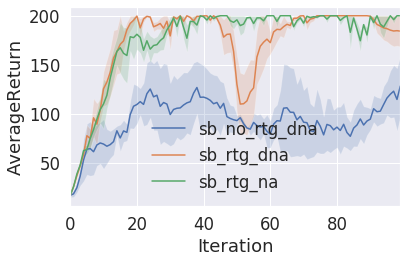


Results with the large batch:


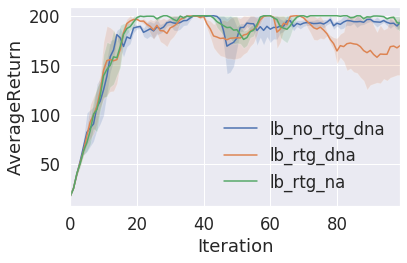

In [4]:
# Adjust files in these two lists! The following is an example from my system where
# I had these as my directory names.

lb_experiments = [
    'lb_no_rtg_dna_CartPole-v0_18-10-2019_23-19-18',
    'lb_rtg_dna_CartPole-v0_18-10-2019_23-22-18',
    'lb_rtg_na_CartPole-v0_18-10-2019_23-28-36',
]

sb_experiments = [
    'sb_no_rtg_dna_CartPole-v0_18-10-2019_23-15-51',
    'sb_rtg_dna_CartPole-v0_18-10-2019_23-16-29',
    'sb_rtg_na_CartPole-v0_18-10-2019_23-17-53',
]
    

# DON'T CHANGE THE FOLLOWING CODE !! If you want to do more experimentation than
# what we have here, that's fine, but do that in the cells at the end of the notebook.
print("Results with the small batch:")
plot(sb_experiments, head='data_pg', legend=None, value='AverageReturn')
print("\nResults with the large batch:")
plot(lb_experiments, head='data_pg', legend=None, value='AverageReturn')

## Short-Answer Questions

Write your answers to the questions we asked in the deliverable above.

- Which gradient estimator has better performance without advantage-centering— the trajectory-centric one, or the one using reward-to-go?

The gradient estimator using reward-to-go has better performance.

- Did advantage centering help?

Yes. Advantage normalization helps the agent to be more stable for both small and large batch.

- Did the batch size make an impact?

Yes. It decreases the variance in the rewards but does not make the agent learn faster.

# Deliverable 2 of 2: Policy Gradients on Pendulum-v0

In this subsection, you will run another classic control problem, Pendulum-v0,
which is continuous control with action dimension one. Pendulum is a relatively
harder and unstable task compared to CartPole, and it is difficult to
consistently get above -1000 with vanilla policy gradients.  Thus, in this part
of the assignment we will do some hyperparameter tuning. Tune the batch size and
learning rate parameters by running the following command:

```
python train_pg.py Pendulum-v0 -ep 1000 --discount 0.99 -n 400 -e 3 -rtg \
        -b <b*> -lr <l*> --exp_name pend_b_<*b>_lr_<l*>
```

while varying the values for the batch size `b*` and the learning rate `l*`.

Report two plots in your writeup, corresponding to the best two hyperparameter
combinations that you tried. Please use the same code we provided earlier. *Each plot
should be the average of AT LEAST three random seeds.*

In addition, report all values of the two hyperparameters you tried, and comment
on the overall performance.

Results with the small batch:


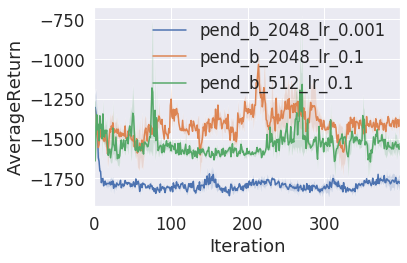

In [10]:
# TODO put your answers and two plots here!
# It's probably easiest to use the same plotting code that we did earlier but if you *really*
# need to modify it, it might be best just to rewrite the plotting script in this ceoo.
pend_experiments = [
    #'pend_b_1024_lr_0.001_Pendulum-v0_19-10-2019_01-18-49',
    #'pend_b_1024_lr_0.01_Pendulum-v0_19-10-2019_01-26-41',
    #'pend_b_1024_lr_0.1_Pendulum-v0_19-10-2019_01-34-26',
    'pend_b_2048_lr_0.001_Pendulum-v0_19-10-2019_01-42-14',
    #'pend_b_2048_lr_0.01_Pendulum-v0_19-10-2019_01-55-45',
    'pend_b_2048_lr_0.1_Pendulum-v0_19-10-2019_02-09-16',
    #'pend_b_512_lr_0.001_Pendulum-v0_19-10-2019_01-06-20',
    #'pend_b_512_lr_0.01_Pendulum-v0_19-10-2019_01-10-17',
    'pend_b_512_lr_0.1_Pendulum-v0_19-10-2019_01-14-12',
]
    

# DON'T CHANGE THE FOLLOWING CODE !! If you want to do more experimentation than
# what we have here, that's fine, but do that in the cells at the end of the notebook.
print("Results with the small batch:")
plot(pend_experiments, head='data_pg', legend=None, value='AverageReturn')

We experimented with learning rate of 0.1, 0.01, 0.001 and batch size of 512, 1024, and 2048. We find learning rate of 0.1 and high batch size works best. But as the problem description said, its difficult to get above -1000 consistently. We have trouble getting above -1000 and the only experiment that got to -1000 has batch size of 2048 and learning rate of 0.1.

# Anything Else

If you'd like to try out more extensions or other things, feel free to put your comments and results here.